# About

Implement a machine learning algorithm with gradient descent on a neuronal population model with delays, in order to find an optimal matrix of delay distribution such that the objective function $L(r)$ is maximized.

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import scipy.integrate as integrate
from scipy import stats
from scipy.spatial import distance
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.transforms as tsfm
import matplotlib.colors as clr
from tqdm.notebook import tqdm
import math
from math import pi
import pandas as pd
from tqdm.notebook import tqdm 


from lib import *

from IPython.display import clear_output

# Dummy data

In [2]:
# Dummy values
N = 30
r0 = np.ones(N) # Baseline firing rate

# Connectivity matrix (positive normal)
normalStd = 1.5
W = np.random.normal(0,normalStd,(N,N))
W = W*(W >= 0) # If W < 0, equate to zero.

# Axonal lengths and initial delays
gammashape = 3.0
gammarate = 2.0
dists = np.random.gamma(gammashape, gammarate, (N,N))
vel0 = 3.0 # Initial velocity
tau0 = dists / vel0 # Iniitial delays

# Import data

In [3]:
foldername = os.path.join(os.getcwd(), 'data', 'matrices', 'ICBM')
filename_names = os.path.join(foldername, 'freesurfer_regions_68_sort_full.txt')
filename_pos = os.path.join(foldername, 'fs_region_centers_68_sort.txt')
filename_conn = os.path.join(foldername, 'icbm_fiber_mat.txt')

In [4]:
vel0 = 3.0 # Initial velocity

W = np.loadtxt(fname = filename_conn)
pos = np.loadtxt(fname = filename_pos)

dist = distance.cdist(pos,pos,'euclidean')
tau0 = dist / vel0

N = W.shape[0]
r0 = np.ones(N) # Baseline firing rate

W = W / np.max(W)

# Parameters 

In [1]:
kappa = 0.0005
# Test if initial gamma is correct (compare with MATLAB)
gamma0 = FunLib.coincidenceFactor(kappa, W, tau0)

NameError: name 'FunLib' is not defined

# Employ learning model

In [6]:
# Learning parameters
eta = 200
numIters = 3000
time = range(numIters)

r_i = r0
tau = tau0
objective = np.zeros(numIters)

for i in tqdm(time):
    
    # Determine the equilibrium solution using current delays
    gamma = FunLib.coincidenceFactor(kappa, W, tau)
    T = np.linalg.inv(np.identity(N) - W*gamma/N) # Not safe
    r_i = np.matmul(T,r0)
    
    # Store objective
    objective[i] = FunLib.objectiveFun(r_i)
    
    # Modify delays
    tau = tau - eta*kappa*r_i[:,np.newaxis]*r_i*W*gamma*FunLib.sumDiffs(W, tau)/N

  0%|          | 0/3000 [00:00<?, ?it/s]

# Figures

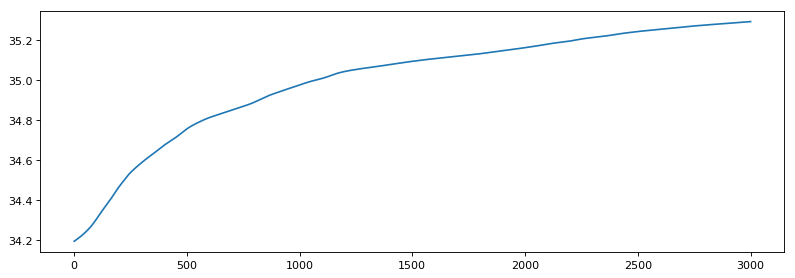

In [7]:
fig, ax = plt.subplots(1, figsize=(12,4), dpi=80)
iters = np.arange(1,numIters+1)
ax.plot(iters, objective)

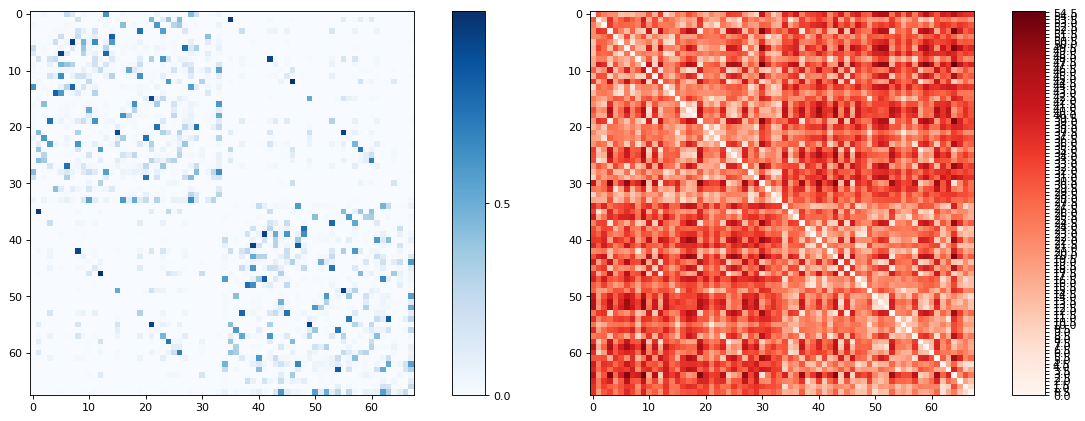

In [8]:
# Positions [left, bottom, width, height] 
bbox0 = [0.05, 0.1, 0.35, 0.80]
bbox1 = [0.43, 0.1, 0.03, 0.80]
bbox2 = [0.55, 0.1, 0.35, 0.80]
bbox3 = [0.93, 0.1, 0.03, 0.80]

fig, ax = plt.subplots(4, figsize=(14,6), dpi=80)

ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)

cs1 = ax[0].imshow(W, cmap='Blues')
cs2 = ax[2].imshow(tau0, cmap='Reds')

# Colour bars
ticks1 = np.arange(0, np.max(W), 0.5) # Connectivity strength
ticks2 = np.arange(0, np.max(tau0), 0.5) # Delays

fig.colorbar(cs1, cax=ax[1], ticks=ticks1)
fig.colorbar(cs2, cax=ax[3], ticks=ticks2)

In [9]:
# Plot the connectivity matrix, axonal lengths, and histogram of velocity/delays before and after.